# Trabajo Práctico 2

## Page Rank de Actores y Actrices

In [1]:
import os
from bs4 import BeautifulSoup

wd = os.getcwd()
if 'TP2' not in wd: wd += '/TP2'

DIR = f'{wd}/paginas'
PAGINAS = os.listdir(DIR)

links = [] # Lista de tuplas de src->dst
palabras = {} # Dict de pagina: palabras

for f in PAGINAS:
    with open(os.path.join(DIR, f)) as file:
        soup = BeautifulSoup(file.read())
        palabras[f] = soup.get_text().split()

        for link in soup.find_all('a'):
            dst = link.get('href').replace('http://','')
            links.append((f,dst))

links

[('angelinajolie.html', 'jonvoight.html'),
 ('angelinajolie.html', 'bradpitt.html'),
 ('bradpitt.html', 'jenniferaniston.html'),
 ('bradpitt.html', 'angelinajolie.html'),
 ('bradpitt.html', 'martinscorcese.html'),
 ('bradpitt.html', 'angelinajolie.html'),
 ('jonvoight.html', 'angelinajolie.html'),
 ('jonvoight.html', 'angelinajolie.html'),
 ('jonvoight.html', 'bradpitt.html'),
 ('robertdeniro.html', 'martinscorcese.html')]

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    'figure.figsize': (10, 6),
}
pylab.rcParams.update(params)

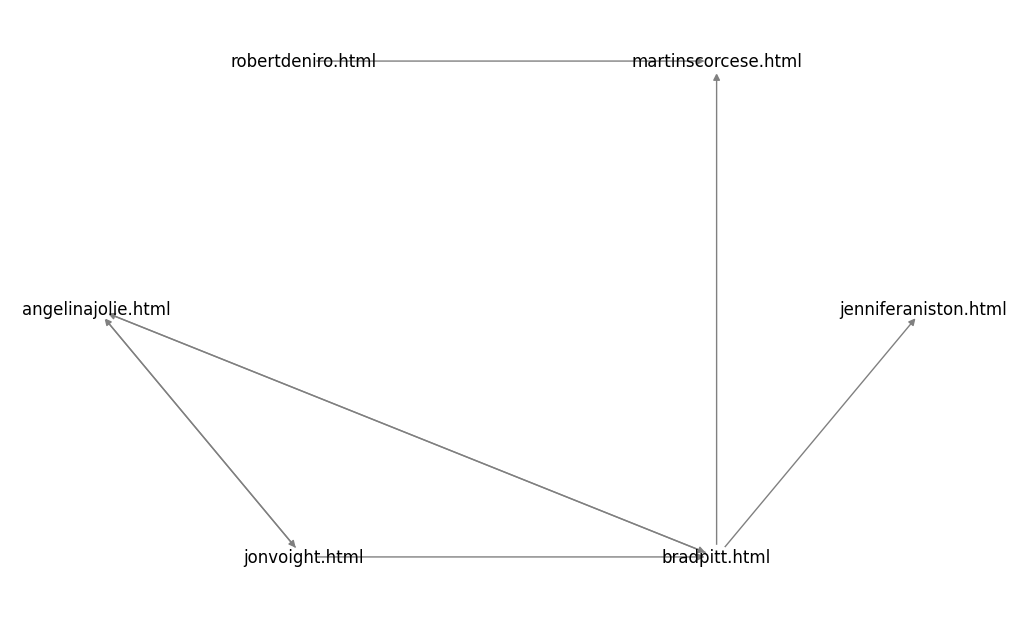

In [3]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(links)
nx.draw_shell(G, with_labels=True, node_color='white', edge_color='grey')

In [4]:
matriz_ady = nx.to_pandas_adjacency(G)
matriz_ady

,angelinajolie.html,jonvoight.html,bradpitt.html,jenniferaniston.html,martinscorcese.html,robertdeniro.html
angelinajolie.html,0.0,1.0,1.0,0.0,0.0,0.0
jonvoight.html,1.0,0.0,1.0,0.0,0.0,0.0
bradpitt.html,1.0,0.0,0.0,1.0,1.0,0.0
jenniferaniston.html,0.0,0.0,0.0,0.0,0.0,0.0
martinscorcese.html,0.0,0.0,0.0,0.0,0.0,0.0
robertdeniro.html,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
suma_filas = matriz_ady.sum(axis=1)
matriz_page_rank = matriz_ady.div(suma_filas, axis=0)
matriz_page_rank.fillna(1/len(PAGINAS), inplace=True)
matriz_page_rank

,angelinajolie.html,jonvoight.html,bradpitt.html,jenniferaniston.html,martinscorcese.html,robertdeniro.html
angelinajolie.html,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
jonvoight.html,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000
bradpitt.html,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000
jenniferaniston.html,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
martinscorcese.html,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
robertdeniro.html,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [6]:
import numpy as np

# Hacemos N iteraciones de la matriz
iteraciones = np.linalg.matrix_power(matriz_page_rank, 50)

page_rank = {p: iteraciones[0][i] for i, p in enumerate(matriz_page_rank.index)}
page_rank

{'angelinajolie.html': 0.2162162162162164,
 'jonvoight.html': 0.16216216216216114,
 'bradpitt.html': 0.2432432432432427,
 'jenniferaniston.html': 0.13513513513513484,
 'martinscorcese.html': 0.18918918918918878,
 'robertdeniro.html': 0.05405405405405395}

In [7]:
import random

BUSQUEDAS = 20

todas_palabras = set()
for p in palabras.values():
    todas_palabras.update(p)

for p in random.choices(list(todas_palabras), k=BUSQUEDAS):
    matches = [f for f in PAGINAS if p in palabras[f]]
    print(f"'{p}' aparece en: {sorted(matches, key=lambda x: -page_rank[x])}")

'conflicted,' aparece en: ['robertdeniro.html']
'landmark' aparece en: ['martinscorcese.html', 'jonvoight.html']
'Miller' aparece en: ['angelinajolie.html']
'preservation' aparece en: ['martinscorcese.html']
'Niro.[2]' aparece en: ['martinscorcese.html']
'founder' aparece en: ['martinscorcese.html']
'hit' aparece en: ['bradpitt.html']
'best' aparece en: ['robertdeniro.html']
'Marcantonio' aparece en: ['martinscorcese.html']
'Roman' aparece en: ['martinscorcese.html']
'earned' aparece en: ['bradpitt.html', 'martinscorcese.html', 'jonvoight.html']
'motion' aparece en: ['martinscorcese.html']
'method' aparece en: ['robertdeniro.html']
'director' aparece en: ['robertdeniro.html']
'Life' aparece en: ['martinscorcese.html']
'While' aparece en: ['jenniferaniston.html']
'School' aparece en: ['martinscorcese.html']
'Vivienne.' aparece en: ['bradpitt.html', 'angelinajolie.html']
'low-budget' aparece en: ['angelinajolie.html']
'17,' aparece en: ['martinscorcese.html', 'robertdeniro.html']


# Ejercicio 2

En base a lo presentado en el trabajo “Queuing theory application in imaging service analysis for small Earth
observation satellites”, simular los resultados obtenidos sobre la longitud de imágenes en cola esperando ser
procesadas en la sección 3.1. Pure image capture service system
El ejercicio se puede resolver utilizando simpy o programación tradicional (a elección del grupo)

### Notas sobre el paper 

### **El paper**

El paper trata de la aplicación de la teoría de colas al procesamiento de solicitudes de captura de imágenes satelitales. En particular el modelo descrito consta de dos etapas: la captura de imágenes y la descarga de imágenes. A continuación intentaremos replicar los resultados obtenidos al modelar el servicio que procesa solicitudes de captura de imágenes, descrito en la sección 3.1 del paper.

### **El modelo**

El servicio de captura de imágenes inicia con al llegada de una solicitud, y termina con la captura de la imágen solicitada. 

Las solicitudes de captura de imágenes ingresan a la cola de acuerdo con un proceso de poisson de tasa $\lambda$. 

Adicionalmente el modelo supone lo siguiente:

*   No hay límite a la longitud de la cola de solicitudes.
*   La politica de atención de solicitudes es FOFS (se priorizan las imagenes de las ubicaciones más cercanas en la ruta del satélite).
*   Las ubicaciones de las solicitudes están distribuidas de manera uniforme sobre el planeta.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import seaborn as sns

def generar_exponencial(lambda_):           
    u_1 = random.random()
    return -np.log(u_1)/lambda_

In [9]:
class Metricas():
    def __init__(self, tasa_arribos, tasa_servicio):
        self.tasa_arribos = tasa_arribos
        self.tasa_servicio = tasa_servicio
        self.arribos = []
        self.salidas = []
        self.tiempo_en_cola = []
        self.tiempos_totales = []
        self.cantidad_en_cola = []
        self.tiempos_de_servicio = []
        self.tiempos_de_servicio_cola = []
        self.tasa_servicio_media_segun_largo_cola = []
        self.longitudMediaTeorica = 0
        self.longitudMediaEmpirica = 0
        self.tiempoMedioTeorico = 0
        self.tiempoMedioEmpirico = 0

    def calcular_metricas_paper(self):
        self.longitudMediaEmpirica = np.mean(self.cantidad_en_cola)
        self.longitudMediaTeorica =  (self.tasa_arribos/self.tasa_servicio)*np.e**(self.tasa_arribos/self.tasa_servicio)
        self.tiempoMedioEmpirico = np.mean(self.tiempos_totales)
        self.tiempoMedioTeorico = np.e**(self.tasa_arribos/self.tasa_servicio)/(self.tasa_servicio)
        #print(f'Tiempo de espera promedio obtenido de la simulación: {self.tiempoMedioEmpirico}')
        #print(f'Tiempo de espera promedio según el modelo: {self.tiempoMedioTeorico}')
        #print(f'Longitud de la cola promedio obtenida de la simulación: {self.longitudMediaEmpirica}')
        #print(f'Longitud de la cola promedio según el modelo: {self.longitudMediaTeorica}')

In [10]:
#generador para modelar la llegada de solicitudes
def solicitud(env, servicio, cant_arribos, tasa_arribos, tasa_servicio, metricas):
    solID = 0
    while solID < cant_arribos:
        t_solicitud_media = 1/tasa_arribos
        #t_solicitud = np.random.exponential(t_solicitud_media)
        t_solicitud = generar_exponencial(tasa_arribos)
        yield env.timeout(t_solicitud)
        metricas.arribos.append(env.now)
        solID += 1
        env.process(captura_imagen(env, servicio, solID, tasa_servicio, metricas))

In [11]:
#generador para modelar el servicio de captura de imágenes
def captura_imagen(env, servicio, solID, tasa_servicio, metricas):
    with servicio.request(priority=1) as req:
        m = len(servicio.queue)
        n = max(1, m)
        media_tiempos_de_servicio = 1/(tasa_servicio*n)
        tiempo_de_servicio = generar_exponencial(tasa_servicio)
        tiempo_de_servicio_cola = tiempo_de_servicio/n
        metricas.tasa_servicio_media_segun_largo_cola.append(1/tiempo_de_servicio_cola)
        metricas.tiempos_de_servicio.append(tiempo_de_servicio)
        metricas.tiempos_de_servicio_cola.append(tiempo_de_servicio_cola)
        metricas.cantidad_en_cola.append(len(servicio.queue))
        inicio_espera = env.now
        yield req
        fin_espera = env.now
        inicio_servicio = env.now
        yield env.timeout(tiempo_de_servicio_cola)
        fin_servicio = env.now
        metricas.tiempo_en_cola.append(fin_espera - inicio_espera)
        metricas.tiempos_totales.append(fin_servicio - inicio_espera)
        metricas.salidas.append(env.now)

In [12]:
#inicio la simulación
def simular(cant_satelites, cant_arribos, tasa_arribos, tasa_servicio, semilla):

    metricas = Metricas(tasa_arribos, tasa_servicio)
    env = simpy.Environment()
    servicio = simpy.PriorityResource(env, capacity = cant_satelites)
    np.random.seed(seed=semilla)
    print(f'Simulando {cant_arribos} arribos con lambdaArribos = {tasa_arribos} y lambdaServicio = {tasa_servicio}')
    env.process(solicitud(env, servicio, cant_arribos, tasa_arribos, tasa_servicio, metricas))
    env.run()
    return metricas

In [13]:
metricasHist = []
a_arribos = np.linspace(0.5, 1.5, 3)
a_llegadas = np.linspace(0.5, 1.5, 3)
longitudes = []
tiempos = []
cantidades_y_tasa_media = []
k=0
for i in a_arribos:
    for j in a_llegadas:
        print(k)
        k=k+1
        metricas = simular(cant_satelites=1, cant_arribos=100, tasa_arribos=i, tasa_servicio=j, semilla=97568)
        metricas.calcular_metricas_paper()
        longitudes.append((metricas.longitudMediaTeorica, metricas.longitudMediaEmpirica))
        tiempos.append((metricas.tiempoMedioTeorico, metricas.tiempoMedioEmpirico))
        cantidades_y_tasa_media.append((np.mean(metricas.cantidad_en_cola), (np.mean(metricas.tasa_servicio_media_segun_largo_cola))))
        metricasHist.append(metricas)

0
Simulando 100 arribos con lambdaArribos = 0.5 y lambdaServicio = 0.5
1
Simulando 100 arribos con lambdaArribos = 0.5 y lambdaServicio = 1.0
2
Simulando 100 arribos con lambdaArribos = 0.5 y lambdaServicio = 1.5
3
Simulando 100 arribos con lambdaArribos = 1.0 y lambdaServicio = 0.5
4
Simulando 100 arribos con lambdaArribos = 1.0 y lambdaServicio = 1.0
5
Simulando 100 arribos con lambdaArribos = 1.0 y lambdaServicio = 1.5
6
Simulando 100 arribos con lambdaArribos = 1.5 y lambdaServicio = 0.5
7
Simulando 100 arribos con lambdaArribos = 1.5 y lambdaServicio = 1.0
8
Simulando 100 arribos con lambdaArribos = 1.5 y lambdaServicio = 1.5


Text(0.5, 0.98, 'Histogramas de solicitudes en cola')

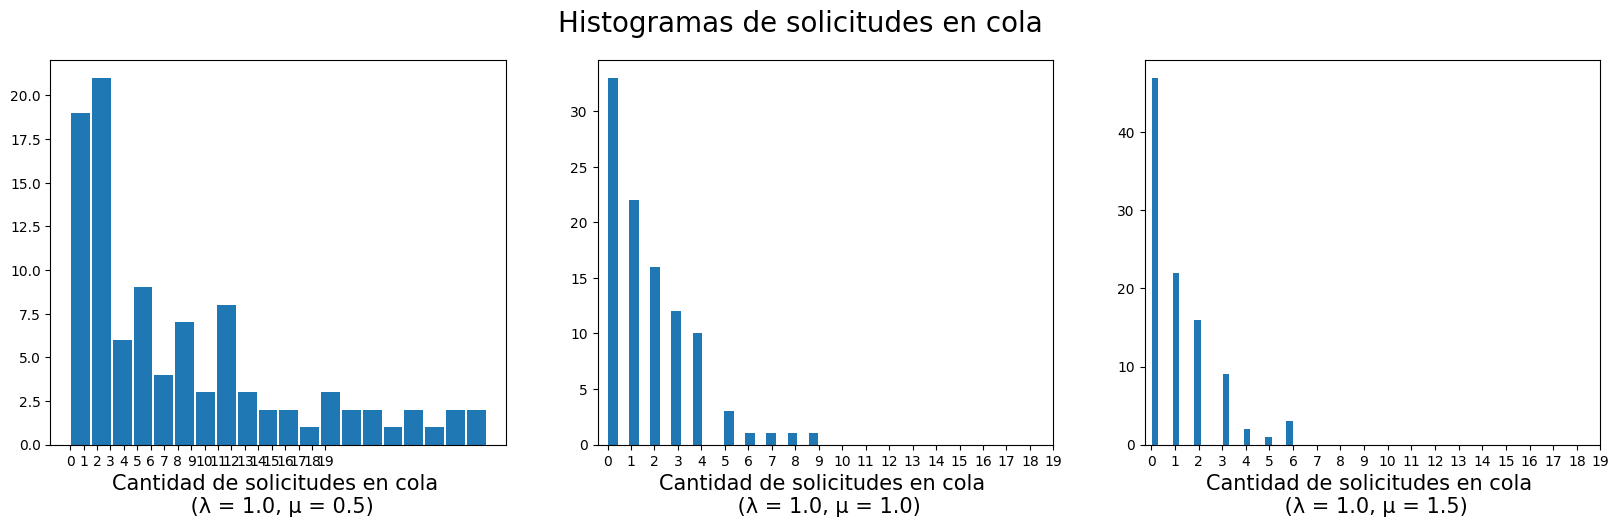

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].hist(metricasHist[3].cantidad_en_cola, 20,rwidth=0.9)
ax[1].hist(metricasHist[4].cantidad_en_cola, 20,rwidth=0.9)
ax[2].hist(metricasHist[5].cantidad_en_cola, 20,rwidth=0.9)
ax[0].set_xticks(np.arange(0, 20, 1))
ax[1].set_xticks(np.arange(0, 20, 1))
ax[2].set_xticks(np.arange(0, 20, 1))
ax[0].set_xlabel(f'Cantidad de solicitudes en cola \n (λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio})', fontsize=15)
ax[1].set_xlabel(f'Cantidad de solicitudes en cola \n (λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio})', fontsize=15)
ax[2].set_xlabel(f'Cantidad de solicitudes en cola \n (λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio})', fontsize=15)
fig.suptitle("Histogramas de solicitudes en cola", fontsize=20)

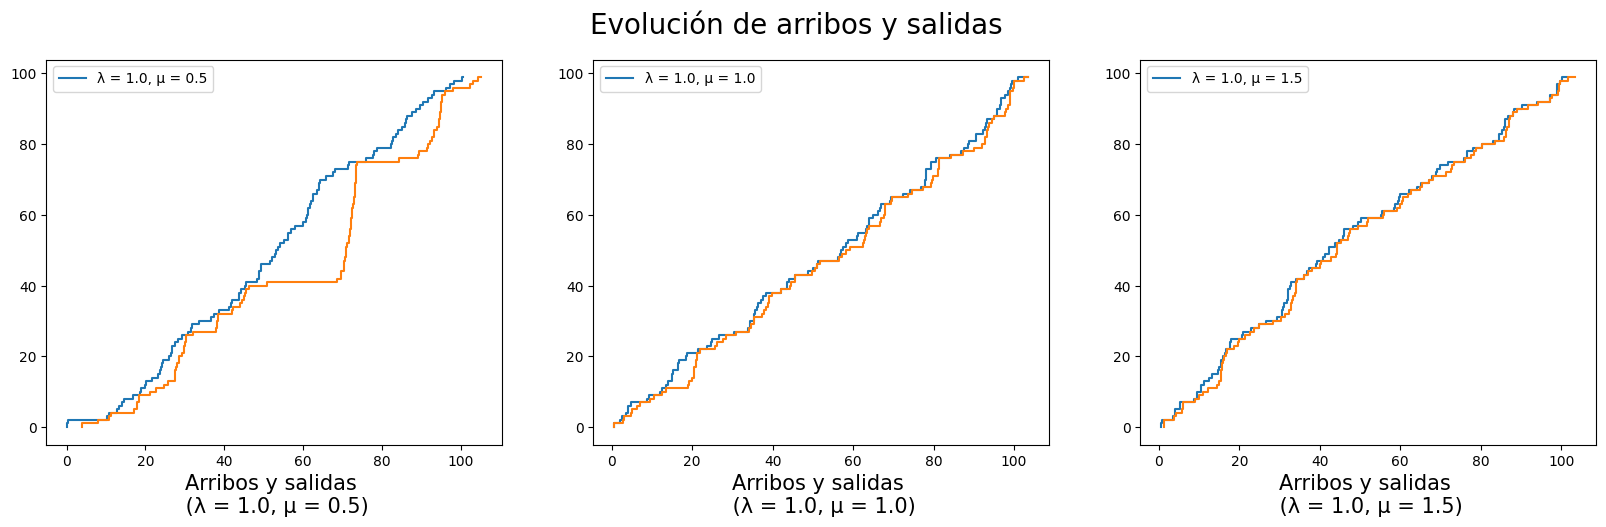

In [15]:
fig, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax3[0].step(x=metricasHist[3].arribos, y=range(len(metricasHist[3].arribos)))
ax3[0].step(x=metricasHist[3].salidas, y=range(len(metricasHist[3].salidas)))
ax3[1].step(x=metricasHist[4].arribos, y=range(len(metricasHist[4].arribos)))
ax3[1].step(x=metricasHist[4].salidas, y=range(len(metricasHist[4].salidas)))
ax3[2].step(x=metricasHist[5].arribos, y=range(len(metricasHist[5].arribos)))
ax3[2].step(x=metricasHist[5].salidas, y=range(len(metricasHist[5].salidas)))
fig.suptitle("Evolución de arribos y salidas", fontsize=20)
ax3[0].set_xlabel(f'Arribos y salidas \n (λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio})', fontsize=15)
ax3[1].set_xlabel(f'Arribos y salidas \n (λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio})', fontsize=15)
ax3[2].set_xlabel(f'Arribos y salidas \n (λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio})', fontsize=15)
ax3[0].legend([f'λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio}'])
ax3[1].legend([f'λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio}'])
ax3[2].legend([f'λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio}'])

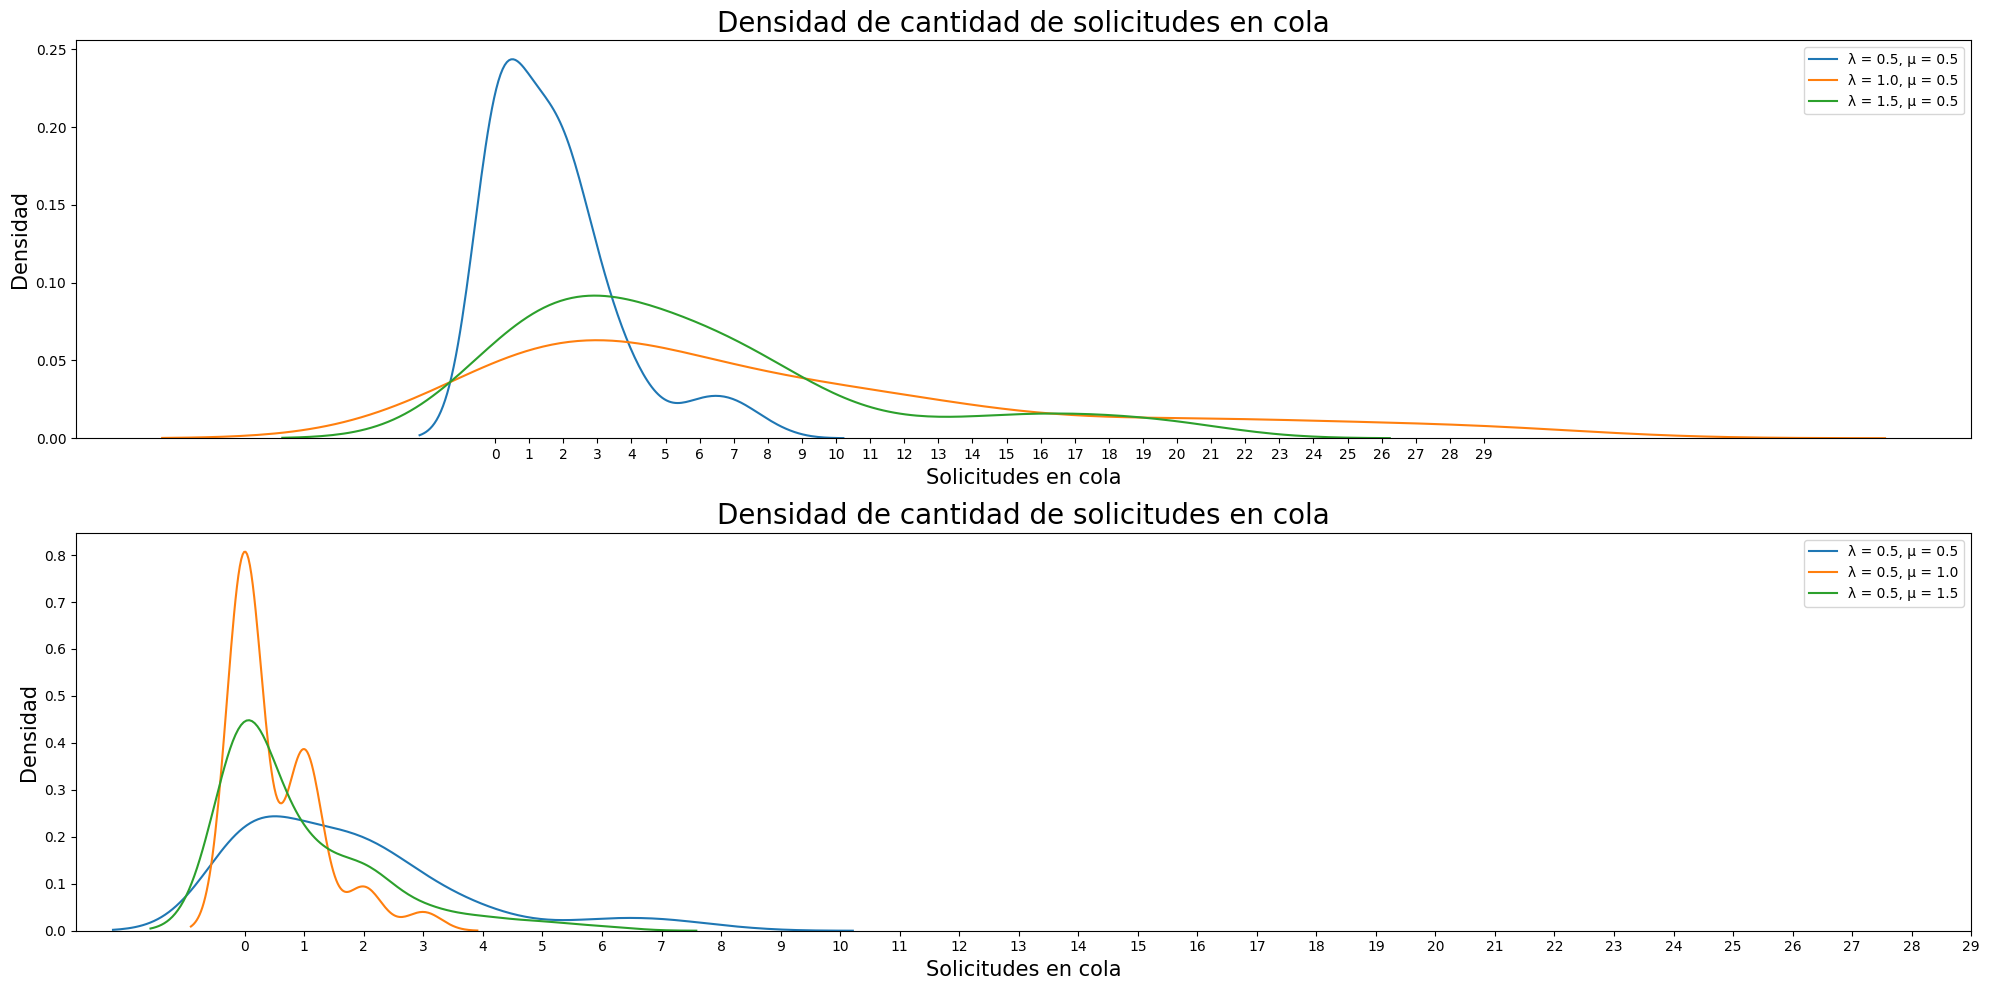

In [16]:
fig, ax4 = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
p = sns.kdeplot(metricasHist[0].cantidad_en_cola,ax=ax4[0])
p = sns.kdeplot(metricasHist[3].cantidad_en_cola,ax=ax4[0])
p = sns.kdeplot(metricasHist[6].cantidad_en_cola,ax=ax4[0])
#p = sns.kdeplot(metricasHist[12].cantidad_en_cola,ax=ax4[0])
p = sns.kdeplot(metricasHist[0].cantidad_en_cola,ax=ax4[1])
p = sns.kdeplot(metricasHist[1].cantidad_en_cola,ax=ax4[1])
p = sns.kdeplot(metricasHist[2].cantidad_en_cola,ax=ax4[1])
#p = sns.kdeplot(metricasHist[3].cantidad_en_cola,ax=ax4[1])
ax4[0].set_xticks(np.arange(0, 30, 1))
ax4[0].legend([f'λ = {metricasHist[0].tasa_arribos}, μ = {metricasHist[0].tasa_servicio}',
               f'λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio}',
               f'λ = {metricasHist[6].tasa_arribos}, μ = {metricasHist[6].tasa_servicio}'])
ax4[0].set_xlabel('Solicitudes en cola', fontsize=15)
ax4[0].set_ylabel('Densidad', fontsize=15)
ax4[0].set_title("Densidad de cantidad de solicitudes en cola", fontsize=20)
ax4[1].set_xticks(np.arange(0, 30, 1))
ax4[1].legend([f'λ = {metricasHist[0].tasa_arribos}, μ = {metricasHist[0].tasa_servicio}',
               f'λ = {metricasHist[1].tasa_arribos}, μ = {metricasHist[1].tasa_servicio}',
               f'λ = {metricasHist[2].tasa_arribos}, μ = {metricasHist[2].tasa_servicio}'])
ax4[1].set_xlabel('Solicitudes en cola', fontsize=15)
ax4[1].set_ylabel('Densidad', fontsize=15)
ax4[1].set_title("Densidad de cantidad de solicitudes en cola", fontsize=20)
fig.tight_layout()

Text(0.5, 1.0, 'Longitudes de cola medias')

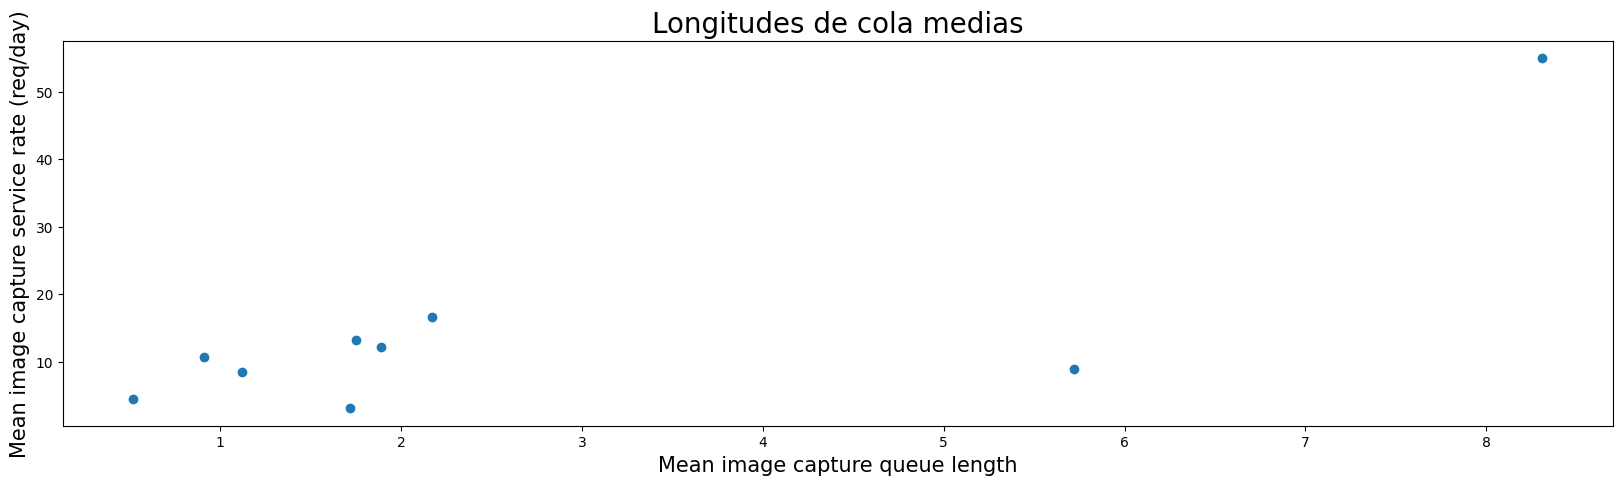

In [17]:
fig, ax5 = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax5.scatter(*zip(*cantidades_y_tasa_media))
ax5.set_xlabel('Mean image capture queue length', fontsize=15)
ax5.set_ylabel('Mean image capture service rate (req/day)', fontsize=15)
ax5.set_title("Longitudes de cola medias", fontsize=20)

Text(0.5, 1.0, 'Tiempos medios de servicio')

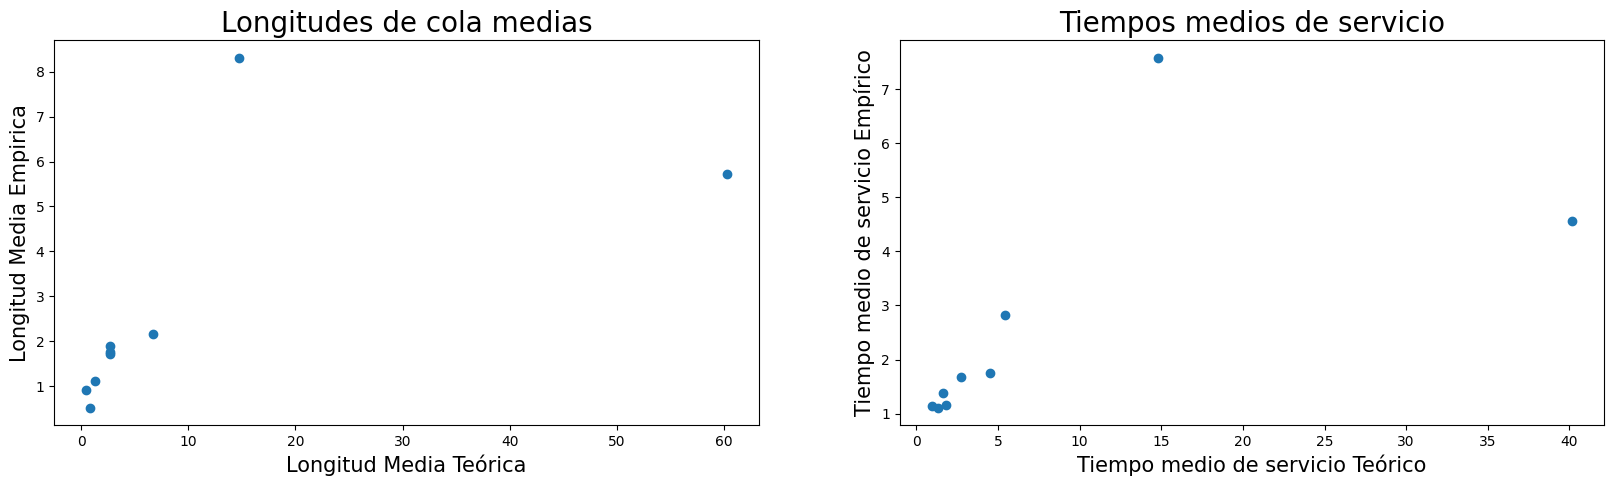

In [18]:
fig, ax6 = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax6[0].scatter(*zip(*longitudes))
ax6[0].set_xlabel('Longitud Media Teórica', fontsize=15)
ax6[0].set_ylabel('Longitud Media Empirica', fontsize=15)
ax6[0].set_title("Longitudes de cola medias", fontsize=20)
ax6[1].scatter(*zip(*tiempos))
ax6[1].set_xlabel('Tiempo medio de servicio Teórico', fontsize=15)
ax6[1].set_ylabel('Tiempo medio de servicio Empírico', fontsize=15)
ax6[1].set_title("Tiempos medios de servicio", fontsize=20)

Text(0.5, 0.98, 'Densidad de tiempos de servicio')

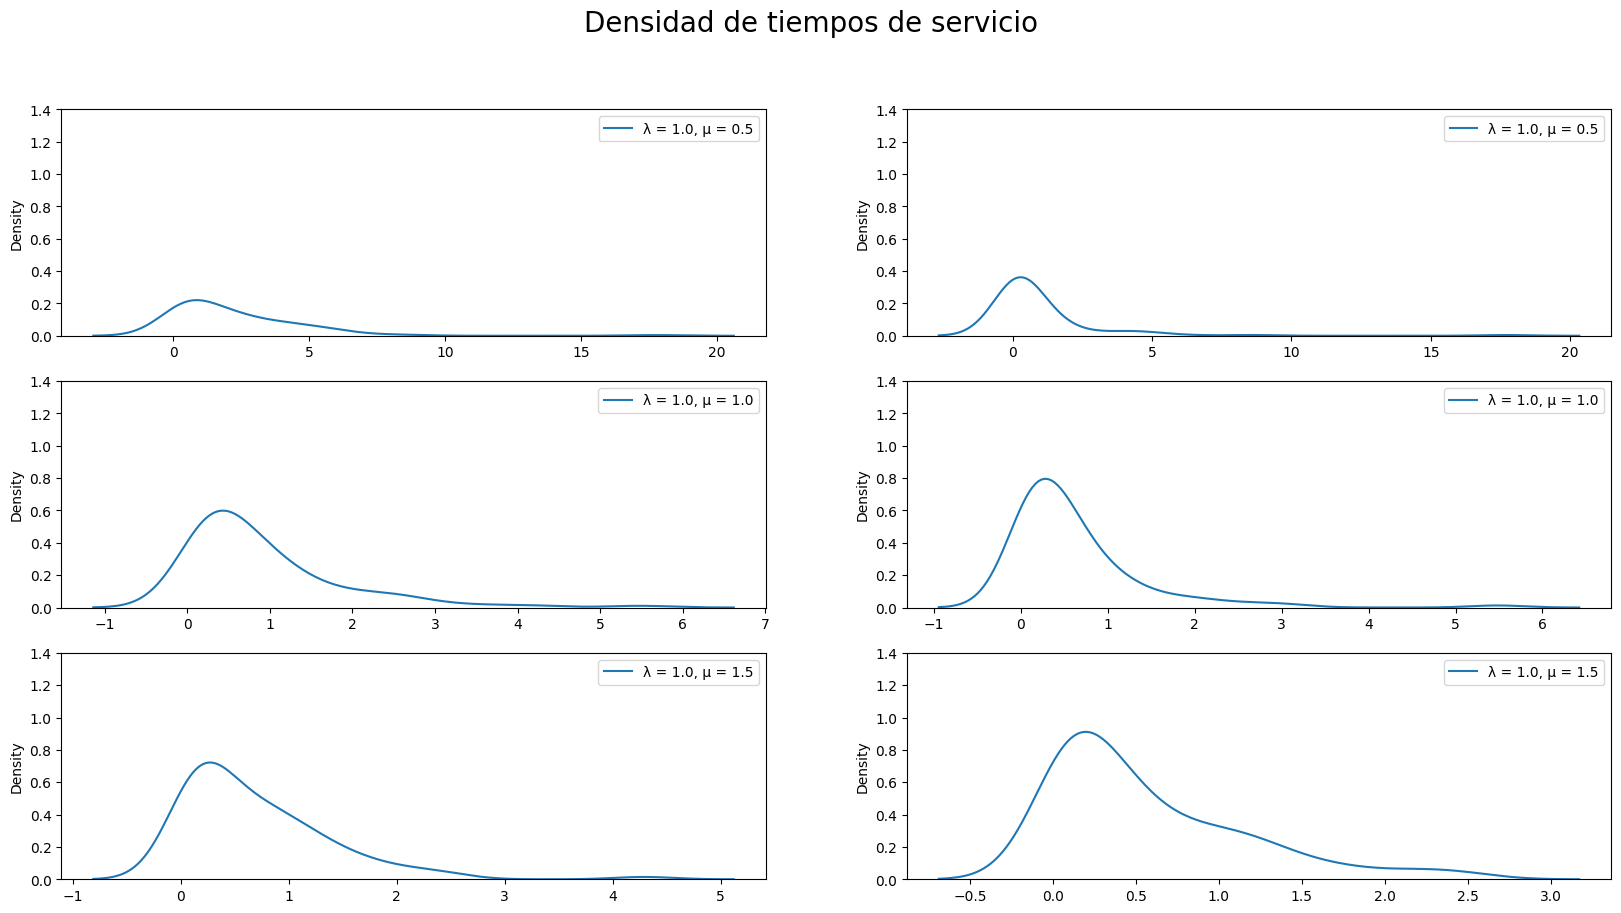

In [19]:
fig, ax7 = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
p = sns.kdeplot(metricasHist[3].tiempos_de_servicio,ax=ax7[0,0])
p = sns.kdeplot(metricasHist[3].tiempos_de_servicio_cola,ax=ax7[0,1])
p = sns.kdeplot(metricasHist[4].tiempos_de_servicio,ax=ax7[1,0])
p = sns.kdeplot(metricasHist[4].tiempos_de_servicio_cola,ax=ax7[1,1])
p = sns.kdeplot(metricasHist[5].tiempos_de_servicio,ax=ax7[2,0])
p = sns.kdeplot(metricasHist[5].tiempos_de_servicio_cola,ax=ax7[2,1])
ax7[0,0].legend([f'λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio}'])
ax7[0,1].legend([f'λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio}'])
ax7[1,0].legend([f'λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio}'])
ax7[1,1].legend([f'λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio}'])
ax7[2,0].legend([f'λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio}'])
ax7[2,1].legend([f'λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio}'])
ax7[0,0].set_yticks(np.arange(0, 1.6, 0.2))
ax7[0,1].set_yticks(np.arange(0, 1.6, 0.2))
ax7[1,0].set_yticks(np.arange(0, 1.6, 0.2))
ax7[1,1].set_yticks(np.arange(0, 1.6, 0.2))
ax7[2,0].set_yticks(np.arange(0, 1.6, 0.2))
ax7[2,1].set_yticks(np.arange(0, 1.6, 0.2))
ax7[0,1].legend([f'λ = {metricasHist[3].tasa_arribos}, μ = {metricasHist[3].tasa_servicio}'])
ax7[1,0].legend([f'λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio}'])
ax7[1,1].legend([f'λ = {metricasHist[4].tasa_arribos}, μ = {metricasHist[4].tasa_servicio}'])
ax7[2,0].legend([f'λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio}'])
ax7[2,1].legend([f'λ = {metricasHist[5].tasa_arribos}, μ = {metricasHist[5].tasa_servicio}'])
#fig.tight_layout()
fig.suptitle("Densidad de tiempos de servicio", fontsize=20)

---

# Diseño del Web Service

In [20]:
from scipy.stats import expon, uniform
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from math import floor

sns.set(style="darkgrid")
params = {
    'axes.titlesize': 20,
    'axes.labelsize': 15,
    'legend.fontsize': 20,
    'figure.figsize': (10, 6),
}
pylab.rcParams.update(params)

In [21]:
class Consulta:
    def __init__(self, tiempo_arribo, duracion, tiempo_finalizacion_anterior):
        if tiempo_arribo < tiempo_finalizacion_anterior:
            self.duracion_espera = tiempo_finalizacion_anterior - tiempo_arribo
            self.tuvo_que_esperar = True
        else:
            self.duracion_espera = 0
            self.tuvo_que_esperar = False
                            
        self.tiempo_finalizacion = tiempo_arribo + duracion + self.duracion_espera

In [22]:
def simular_consultas(tiempos_de_arribo, duraciones):
    consultas = []

    # Uso -1 como tiempo de finalizacion del anterior para que empieze ni bien llega
    primera_consulta = Consulta(tiempos_de_arribo[0], duraciones[0], tiempo_finalizacion_anterior = -1)
    consultas.append(primera_consulta)

    for tiempo_arribo, duracion in zip(tiempos_de_arribo[1:], duraciones[1:]):
        consulta = Consulta(tiempo_arribo,
                        duracion, 
                        tiempo_finalizacion_anterior = consultas[-1].tiempo_finalizacion)
        consultas.append(consulta)
        
    tiempo_espera_total = 0
    cant_consultas_que_no_esperaron = 0
    for consulta in consultas:
        tiempo_espera_total += consulta.duracion_espera
        if not consulta.tuvo_que_esperar:
            cant_consultas_que_no_esperaron += 1

    return tiempo_espera_total, cant_consultas_que_no_esperaron

### Centralizado

In [23]:
def mostrar_resultados(titulo, tiempo_espera_total, cant_consultas_que_no_esperaron, cant_consultas):
    print(f"--------------{titulo}--------------")
    
    
    segundos = round(tiempo_espera_total / cant_consultas, 0)
    
    minutos = floor(segundos/60)
    if(minutos != 0):
        segundos = segundos % (minutos * 60)
    
    horas = floor(minutos/60)
    if(horas != 0):
        minutos = minutos % (horas * 60)

        
    dias = floor(horas/24)
    if(dias != 0):
        horas = horas % (dias * 24)
    
    print(f"\tEl tiempo de espera promedio fue ", end="")
    if(dias != 0):
        print(str(dias) + " Dias ", end="")
    if(horas != 0):    
        print(str(horas) + " Horas ", end="")
    if(minutos != 0):    
        print(str(minutos) + " Minutos ", end="")
    if(segundos != 0):    
        print(str(segundos) + " Segundos")
    
    
    print(f"\tEl {round(cant_consultas_que_no_esperaron/cant_consultas, 5)}% de las consultas no tuvo que esperar")

In [24]:
def simular_consultas_centralizado(cant_consultas, media_tiempos_de_arribo, media_duraciones_consultas):
    tiempos_de_arribo = expon.rvs(size=cant_consultas, scale=media_tiempos_de_arribo, random_state=10)
    duraciones = expon.rvs(size=cant_consultas, scale=media_duraciones_consultas, random_state=10)
    return simular_consultas(tiempos_de_arribo, duraciones)

In [25]:
t, f = simular_consultas_centralizado(100000, 4, 0.8)
mostrar_resultados("Base de datos central", t,f, 100000)

--------------Base de datos central--------------
	El tiempo de espera promedio fue 11 Horas 3 Minutos 16.0 Segundos
	El 2e-05% de las consultas no tuvo que esperar


### Distribuido

In [26]:
def simular_consultas_distribuido(cant_consultas, media_tiempos_de_arribo,
                                  media_duraciones_consultas1, media_duraciones_consultas2, p):
    tiempos_de_arribo = expon.rvs(size=cant_consultas, scale=media_tiempos_de_arribo, random_state=10)
    u = uniform.rvs(size=cant_consultas, random_state=10)
    
    tiempos_de_arribo1 = []
    tiempos_de_arribo2 = []
    
    for ui, tiempo_de_arribo in zip(u, tiempos_de_arribo):
        if p <= ui:
            tiempos_de_arribo1.append(tiempo_de_arribo)
        else:
            tiempos_de_arribo2.append(tiempo_de_arribo)
    
    
    duraciones1 = expon.rvs(size=len(tiempos_de_arribo1), scale=media_duraciones_consultas1, random_state=10)
    t1, f1 = simular_consultas(tiempos_de_arribo1, duraciones1)
    
    duraciones2 = expon.rvs(size=len(tiempos_de_arribo2), scale=media_duraciones_consultas2, random_state=10)
    t2, f2 = simular_consultas(tiempos_de_arribo2, duraciones2)
    
    return t1, f1, len(tiempos_de_arribo1), t2, f2, len(tiempos_de_arribo2)

In [27]:
t1, f1, l1, t2, f2, l2 = simular_consultas_distribuido(100000, 4, 0.7, 1, 0.7)
mostrar_resultados("Ambas bases distribuidas", t1 + t2, f2 + f2, l1 + l2)
mostrar_resultados("Base de datos distribuida 1", t1, f1, l1)
mostrar_resultados("Base de datos distribuida 2", t2, f2, l2)

--------------Ambas bases distribuidas--------------
	El tiempo de espera promedio fue 7 Horas 40 Minutos 21.0 Segundos
	El 4e-05% de las consultas no tuvo que esperar
--------------Base de datos distribuida 1--------------
	El tiempo de espera promedio fue 2 Horas 51 Minutos 34.0 Segundos
	El 7e-05% de las consultas no tuvo que esperar
--------------Base de datos distribuida 2--------------
	El tiempo de espera promedio fue 9 Horas 42 Minutos 30.0 Segundos
	El 3e-05% de las consultas no tuvo que esperar


### Modificando los parametros

In [28]:
def simular_variaciones(cantidades_consultas=[100000], 
                        medias_tiempos_de_arribo=[4],
                        medias_duraciones_consultas = [0.8],  
                        medias_duraciones_consultas1 = [0.7],
                        medias_duraciones_consultas2 = [1],
                        lista_p = [0.7]):

    tiempos_centralizado = []
    frecuencias_centralizado = []

    tiempos_distribuido = []
    frecuencias_distribuido = []
                         
    for cant_consultas in cantidades_consultas:
        for media_tiempos_de_arribo in medias_tiempos_de_arribo:
            for media_duraciones_consultas in medias_duraciones_consultas:
                for media_duraciones_consultas1 in medias_duraciones_consultas1:
                     for media_duraciones_consultas2 in medias_duraciones_consultas2:
                            for p in lista_p:
                                t, f = simular_consultas_centralizado(cant_consultas, media_tiempos_de_arribo, 
                                                                      media_duraciones_consultas)
                                tiempos_centralizado.append(t / cant_consultas)
                                frecuencias_centralizado.append(f /cant_consultas)
    
                                t1, f1, l1, t2, f2, l2  = simular_consultas_distribuido(cant_consultas, 
                                                                                        media_tiempos_de_arribo,
                                                                                        media_duraciones_consultas1,
                                                                                        media_duraciones_consultas2,
                                                                                        p)
    
                                tiempos_distribuido.append((t1 + t2) / (l1 + l2))
                                frecuencias_distribuido.append((f1 + f2) / (l1 + l2))
            
            
    return tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido 

In [29]:
def graficar_tiempo_espera(x, xlabel, tiempos_centralizado, tiempos_distribuido,
                         centralizado_es_referencia = False, distribuido_es_referencia = False):
    
    if centralizado_es_referencia:
        color_centralizado = 'b'
        linestyle_centralizado = '--'
    else:
        color_centralizado = 'bo'
        linestyle_centralizado = '-'
        
    if distribuido_es_referencia:
        color_distribuido = 'g'
        linestyle_distribuido = '--'
    else:
        color_distribuido = 'go'
        linestyle_distribuido = '-'
    
    plt.plot(x, tiempos_centralizado, color_centralizado, linestyle=linestyle_centralizado, label="Base centralizada")
    plt.plot(x, tiempos_distribuido, color_distribuido, linestyle=linestyle_distribuido, label="Bases distribuidas")
    plt.title(f"Tiempo de espera medio según\n{xlabel.lower()}")
    plt.xlabel(xlabel)
    plt.ylabel("Tiempo de espera medio")
    plt.legend()
    plt.show()

In [30]:
def graficar_fraccion_que_no_espero(x, xlabel, tiempos_centralizado, tiempos_distribuido,
    centralizado_es_referencia = False, distribuido_es_referencia = False):
    
    if centralizado_es_referencia:
        color_centralizado = 'b'
        linestyle_centralizado = '--'
    else:
        color_centralizado = 'bo'
        linestyle_centralizado = '-'
        
    if distribuido_es_referencia:
        color_distribuido = 'g'
        linestyle_distribuido = '--'
    else:
        color_distribuido = 'go'
        linestyle_distribuido = '-'
    
    plt.plot(x, tiempos_centralizado, color_centralizado, linestyle=linestyle_centralizado, label="Base centralizada")
    plt.plot(x, tiempos_distribuido, color_distribuido, linestyle=linestyle_distribuido, label="Bases distribuidas")
    plt.title(f"Fracción de solicitudes que no esperaron según\n{xlabel.lower()}")
    plt.xlabel(xlabel)
    plt.ylabel("Fracción de solicitudes que no esperaron")
    plt.legend()

#### Media del tiempo de arribo

In [31]:
medias_tiempos_de_arribo = range(1, 11)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
    medias_tiempos_de_arribo = medias_tiempos_de_arribo
)

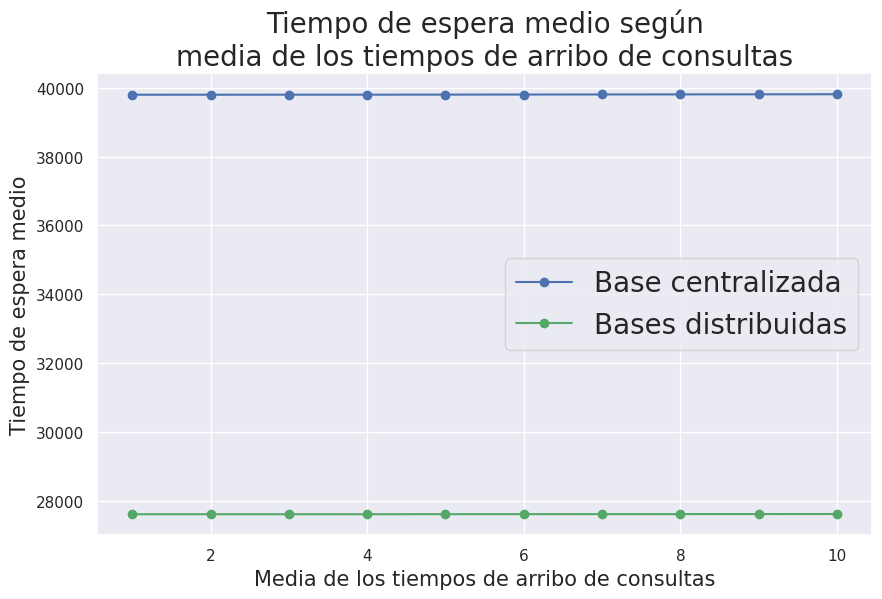

In [32]:
graficar_tiempo_espera(medias_tiempos_de_arribo, "Media de los tiempos de arribo de consultas",
                      tiempos_centralizado, tiempos_distribuido)

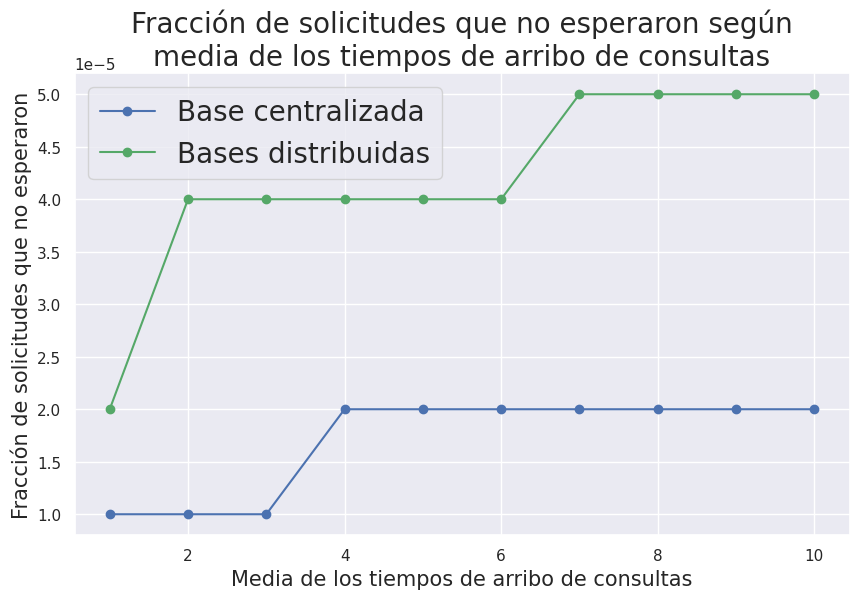

In [33]:
graficar_fraccion_que_no_espero(medias_tiempos_de_arribo, "Media de los tiempos de arribo de consultas",
                      frecuencias_centralizado, frecuencias_distribuido)

#### Lambda

In [34]:
lambda_l = []
for i in range(2, 20, 2):
    lambda_l.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     medias_duraciones_consultas = lambda_l
)

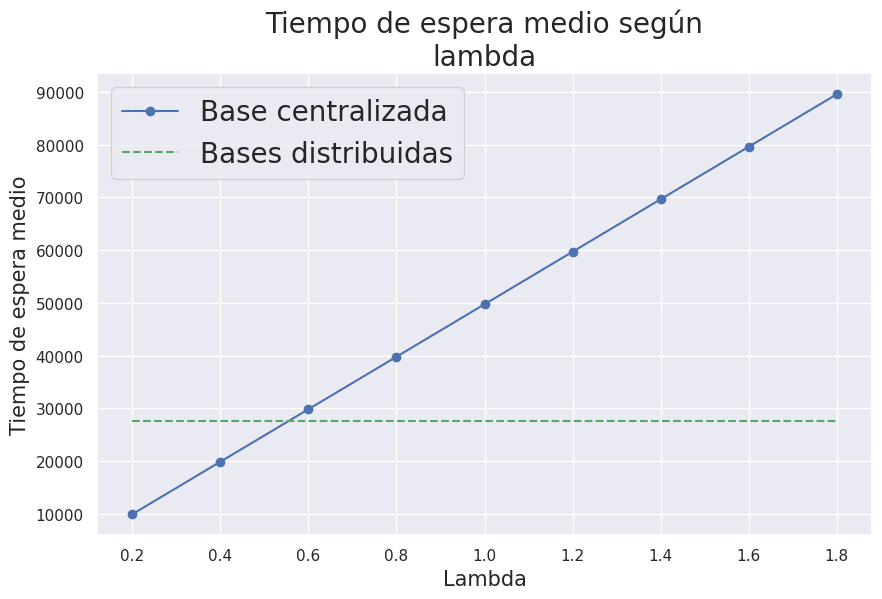

In [35]:
graficar_tiempo_espera(lambda_l, "Lambda",
                      tiempos_centralizado, tiempos_distribuido, distribuido_es_referencia = True)

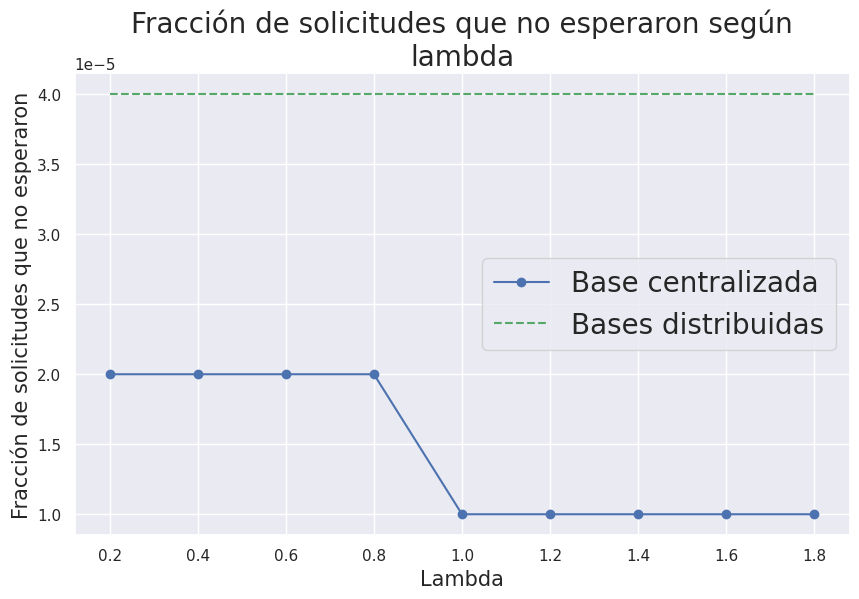

In [36]:
graficar_fraccion_que_no_espero(lambda_l, "Lambda",
                      frecuencias_centralizado, frecuencias_distribuido, distribuido_es_referencia = True)

#### Lambda1

In [37]:
lambda_1 = []
for i in range(2, 20, 2):
    lambda_1.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     medias_duraciones_consultas1 = lambda_1
)

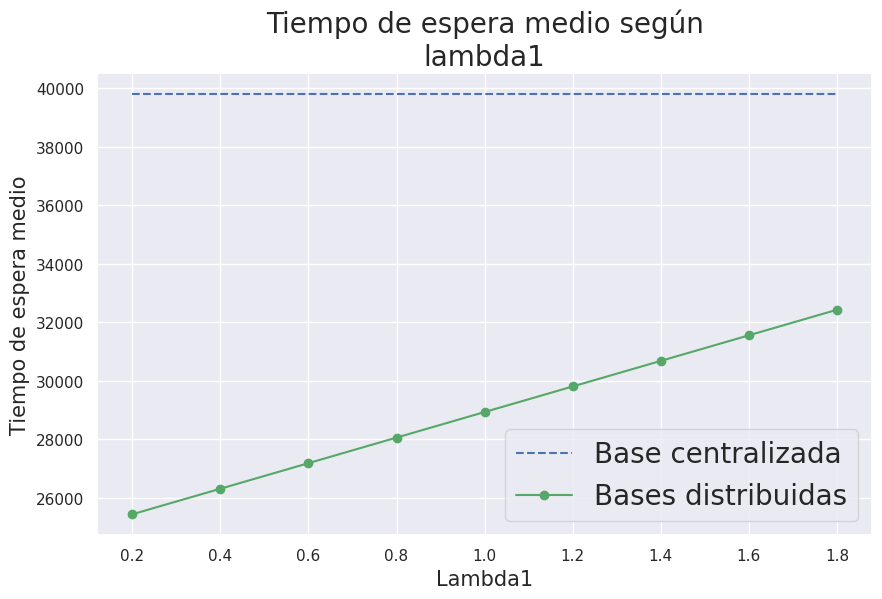

In [38]:
graficar_tiempo_espera(lambda_1, "Lambda1",
                      tiempos_centralizado, tiempos_distribuido, centralizado_es_referencia = True)

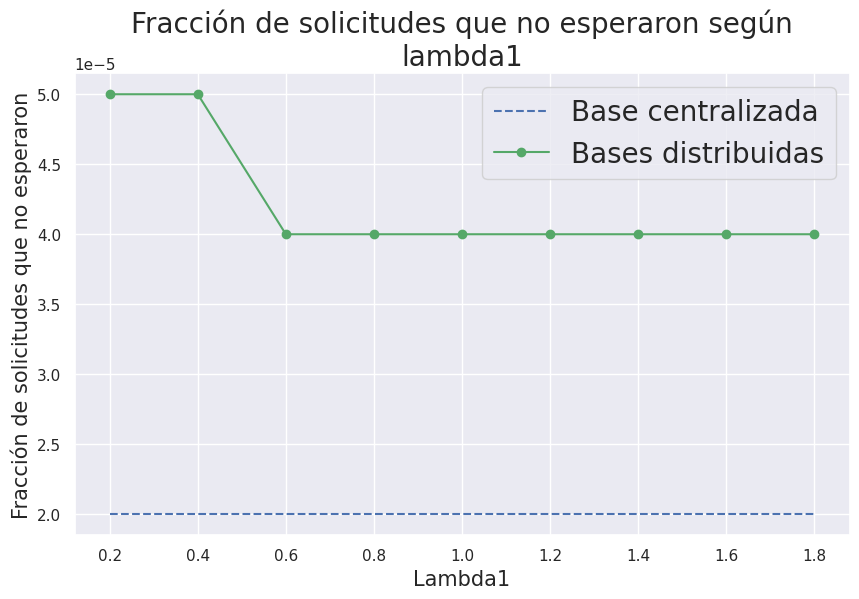

In [39]:
graficar_fraccion_que_no_espero(lambda_1, "Lambda1",
                      frecuencias_centralizado, frecuencias_distribuido, centralizado_es_referencia = True)

#### Lambda2

In [40]:
lambda_2 = []
for i in range(2, 20, 2):
    lambda_2.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     medias_duraciones_consultas1 = lambda_2
)

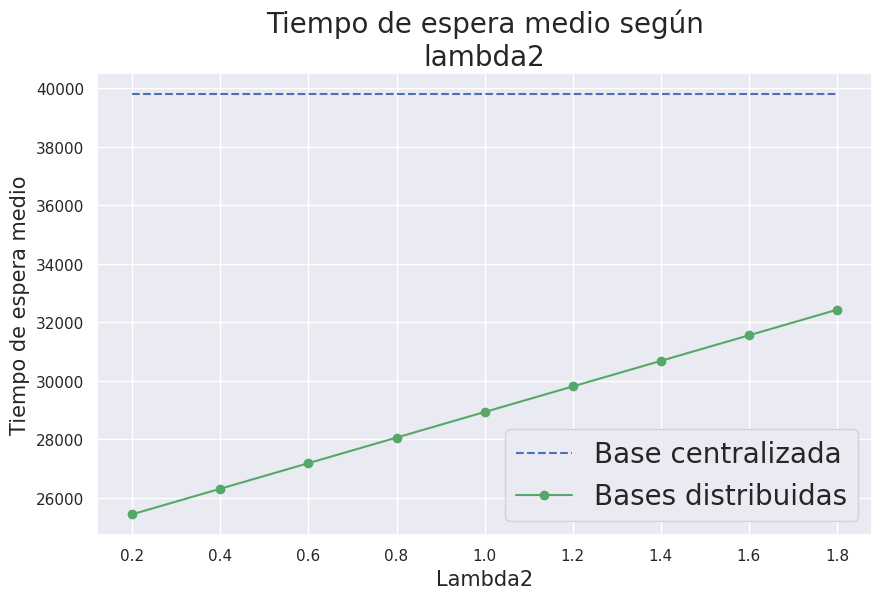

In [41]:
graficar_tiempo_espera(lambda_2, "Lambda2",
                      tiempos_centralizado, tiempos_distribuido, centralizado_es_referencia = True)

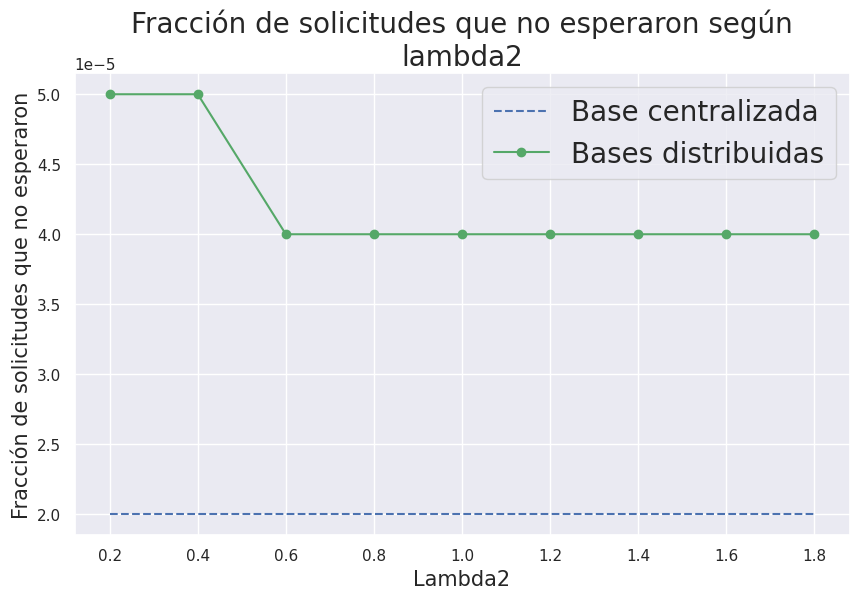

In [42]:
graficar_fraccion_que_no_espero(lambda_2, "Lambda2",
                      frecuencias_centralizado, frecuencias_distribuido, centralizado_es_referencia = True)

#### p

In [43]:
lista_p = []
for i in range(1, 10):
    lista_p.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     lista_p = lista_p
)

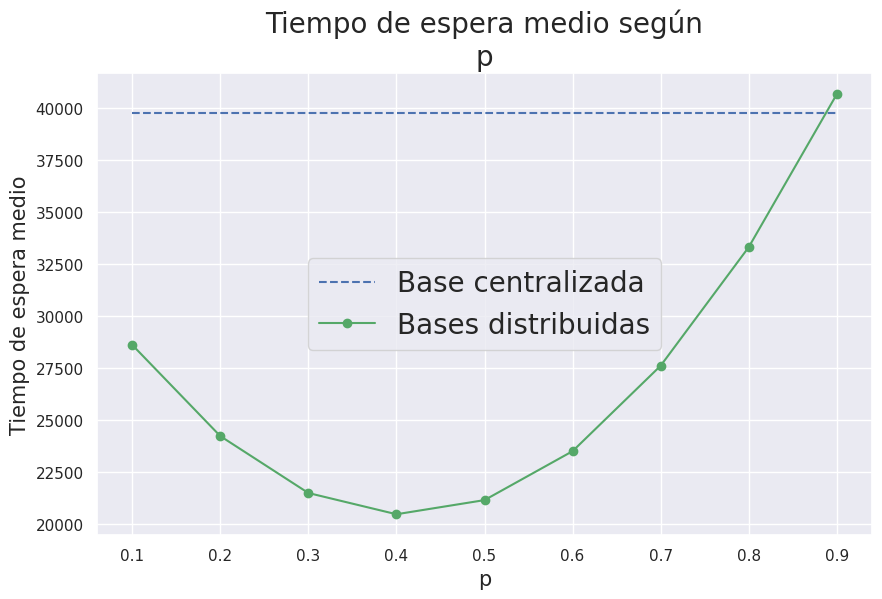

In [44]:
graficar_tiempo_espera(lista_p, "p",
                      tiempos_centralizado, tiempos_distribuido, centralizado_es_referencia = True)

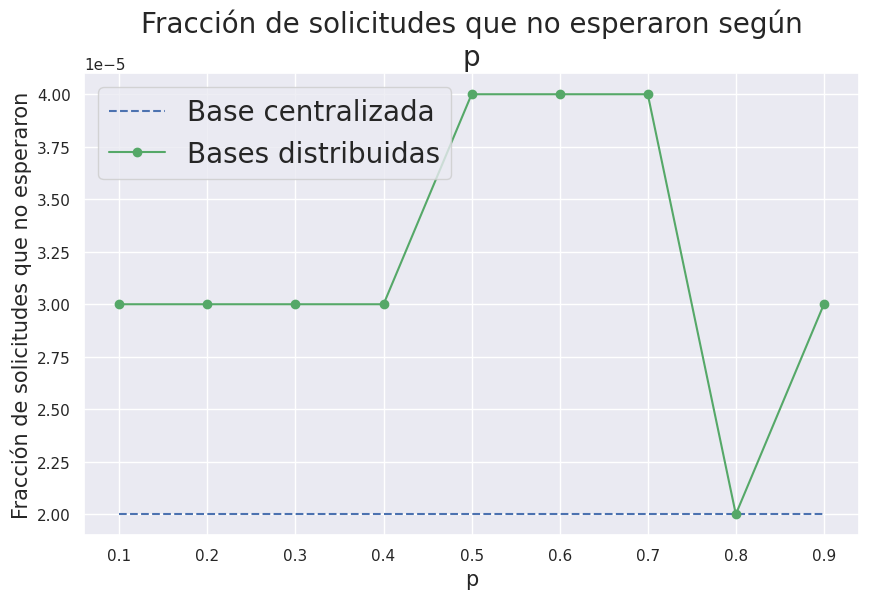

In [45]:
graficar_fraccion_que_no_espero(lista_p, "p",
                      frecuencias_centralizado, frecuencias_distribuido, centralizado_es_referencia = True)